<a href="https://colab.research.google.com/github/abdumhmd/kvasir-segmentation/blob/main/FCN8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models

In [4]:

!unzip /content/drive/MyDrive/kvasir-seg.zip
import os

!mkdir /content/Kvasir-SEG/images/img
!mv /content/Kvasir-SEG/images/*.jpg /content/Kvasir-SEG/images/img
!mkdir /content/Kvasir-SEG/masks/img
!mv /content/Kvasir-SEG/masks/*.jpg /content/Kvasir-SEG/masks/img
images=os.listdir('/content/Kvasir-SEG/images/img')
masks=os.listdir('/content/Kvasir-SEG/masks/img')

print(len(images))
print(len(masks))

Archive:  /content/drive/MyDrive/kvasir-seg.zip
replace Kvasir-SEG/kavsir_bboxes.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg  
  inflating: Kvasir-SEG/images/ck2bxknhjvs1x0794iogrq49k.jpg  
  inflating: Kvasir-SEG/images/ck2bxlujamu330725szlc2jdu.jpg  
  inflating: Kvasir-SEG/images/ck2bxpfgxu2mk0748gsh7xelu.jpg  
  inflating: Kvasir-SEG/images/ck2bxqz3evvg20794iiyv5v2m.jpg  
  inflating: Kvasir-SEG/images/ck2bxskgxxzfv08386xkqtqdy.jpg  
  inflating: Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg  
  inflating: Kvasir-SEG/images/ck2395w2mb4vu07480otsu6tw.jpg  
  inflating: Kvasir-SEG/images/ck2da7fwcjfis07218r1rvm95.jpg  
  inflating: Kvasir-SEG/images/cjyzjzssvd8pq0838f4nolj5l.jpg  
  inflating: Kvasir-SEG/images/cjyzk8qieoboa0848ogj51wwm.jpg  
  inflating: Kvasir-SEG/images/cju5hi52odyf90817prvcwg45.jpg  
  inflating: Kvasir-SEG/images/cju5hjxaae3i40850h5z2laf5.jpg  
  inflating: Kvasir-SEG/images/cju5hl8nee8a40755fm8qjj

(530, 618, 3)

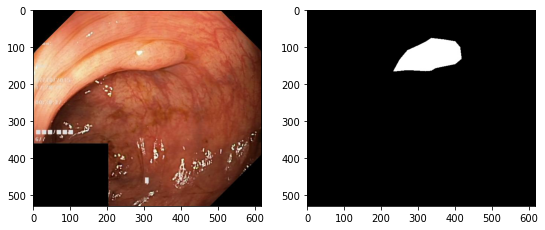

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2)
fig.set_size_inches(9, 9)

img=plt.imread("/content/Kvasir-SEG/images/img/"+images[0])
msk=plt.imread("/content/Kvasir-SEG/masks/img/"+masks[0])
axs[0].imshow(img)
axs[1].imshow(msk)

msk.shape


In [6]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from tqdm import tqdm
import numpy as np
import tensorflow as tf


images_ = []
masks_ =  []
size=(256,256)
for i in tqdm(os.listdir('/content/Kvasir-SEG/images/img/')):
    
    

    img_name = "/content/Kvasir-SEG/images/img/"+ i 
    img_mask = "/content/Kvasir-SEG/masks/img/" + i 
    
    
    
    img = load_img(img_name, target_size=size)
    img = img_to_array(img)/255.
    
    mask = load_img(img_mask, target_size=size,color_mode="grayscale")
    mask = img_to_array(mask)/255.
    images_.append(img)
    masks_.append(mask)
    
images_ =  np.array(images_)
masks_ = np.array(masks_)
print(images_.shape, masks_.shape)
filename = 'maps_256.npz'


100%|██████████| 1000/1000 [00:09<00:00, 105.51it/s]


(1000, 256, 256, 3) (1000, 256, 256, 1)


In [7]:
from numpy import load

#filename = 'maps_256.npz'
# Load training and testing data
#datatrain = load(filename)
X_train, y_train = images_, masks_


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(X_train.shape,X_test.shape,X_valid.shape)

(600, 256, 256, 3) (200, 256, 256, 3) (200, 256, 256, 3)


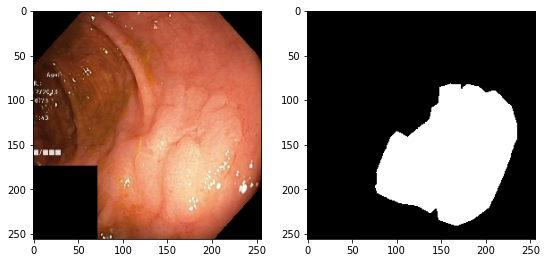

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2)
fig.set_size_inches(9, 9)

axs[0].imshow(X_train[100])
#axs[1].imshow(y_train[55])
axs[1].imshow(np.reshape(y_train[100], (256, 256)), cmap="gray");

In [9]:

from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Input, Cropping2D, add, Dropout, Reshape, Activation


def FCN8_helper(nClasses, input_height=224, input_width=224):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    

    model = vgg16.VGG16(
        include_top=False,
        weights=None, 
        input_shape=(256,256,3),
        pooling=None,
        classes=1000)
    assert isinstance(model, Model)
    for layers in model.layers:
      layers.trainable=False
    o = Conv2D(
        filters=4096,
        kernel_size=(
            7,
            7),
        padding="same",
        activation="relu",
        name="fc6")(
            model.output)
    
    o = Dropout(rate=0.5)(o)
    
    o = Conv2D(
        filters=4096,
        kernel_size=(
            1,
            1),
        padding="same",
        activation="relu",
        name="fc7")(o)
    
    o = Dropout(rate=0.5)(o)

    o = Conv2D(filters=nClasses, kernel_size=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal",
               name="score_fr")(o)

    o = Conv2DTranspose(filters=nClasses, kernel_size=(2, 2), use_bias=False, strides=(2, 2), padding="valid", activation=None,
                        name="score2")(o)

    fcn8 = Model(inputs=model.input, outputs=o)
    # mymodel.summary()
    return fcn8



def FCN8(nClasses, input_height=256, input_width=256):


    fcn8 = FCN8_helper(nClasses, input_height=256, input_width=256)



	# Conv to be applied on Pool4
    skip_con1 = Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal",
                       name="score_pool4")(fcn8.get_layer("block4_pool").output)
    Summed = add(inputs=[skip_con1, fcn8.output])

    x = Conv2DTranspose(nClasses, use_bias=False, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None,
                        name="score4")(Summed)

    ###
    skip_con2 = Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal",
                       name="score_pool3")(fcn8.get_layer("block3_pool").output)
    Summed2 = add(inputs=[skip_con2, x])

    #####
    Up = Conv2DTranspose(nClasses, kernel_size=(8, 8), use_bias=False, strides=(8, 8),
                         padding="valid", activation=None, name="upsample")(Summed2)

    
    Up = Activation("sigmoid")(Up)

    model = Model(inputs=fcn8.input, outputs=Up)


    return model


In [ ]:
model=FCN8(1,256,256)
model.summary()

In [10]:
from __future__ import print_function
from keras.layers import *
from keras.models import Model
'''
Keras+tensorflow conversion of 
https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/voc-fcn8s/net.py

If you use this code please cite:

https://www.scirp.org/journal/PaperInformation.aspx?PaperID=84616

Konovalov, D.A., Hillcoat, S., Williams, G. , Birtles, R. A., Gardiner, N., and Curnock, M. I. (2018) 
Individual Minke Whale Recognition Using Deep Learning Convolutional Neural Networks. 
Journal of Geoscience and Environment Protection, 6, 25-36. doi: 10.4236/gep.2018.65003
'''


def make_vgg16fcn8s_model(input_shape=(256,256,3),   # (256,256,3) is for the tensorflow backend, (3,256,256) for Theano
                          num_classes=None,   # todo: CHANGE to your number of output classes
                          num_conv_filters=4096,  # in our papers we used 1024 and 512
                          use_bias=True,
                          weight_decay=0.,
                          last_activation='softmax'  # or e.g. 'sigmoid'
                          ):
    '''
    Keras+tensorflow conversion of
    https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/voc-fcn8s/net.py

    If you use this code please cite:

    https://www.scirp.org/journal/PaperInformation.aspx?PaperID=84616

Konovalov, D.A., Hillcoat, S., Williams, G. , Birtles, R. A., Gardiner, N., and Curnock, M. I. (2018) 
    Individual Minke Whale Recognition Using Deep Learning Convolutional Neural Networks.
    Journal of Geoscience and Environment Protection, 6, 25-36. doi: 10.4236/gep.2018.65003

    '''
    from keras import regularizers
    wd = weight_decay
    kr = regularizers.l2
    in1 = Input(shape=input_shape)
    # ki = 'he_normal'
    ki = 'glorot_uniform'

    # padding
    y_pad = input_shape[0] % 32
    x_pad = input_shape[1] % 32
    assert y_pad == 0 and x_pad == 0

    from keras.applications.vgg16 import VGG16
    base_model = VGG16(include_top=False, input_tensor=in1, pooling=None)
    # base_model.summary()
    pool3 = base_model.layers[-9].output
    pool4 = base_model.layers[-5].output
    pool5 = base_model.layers[-1].output

    # NOTE no change from 16s
    # https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/voc-fcn8s/net.py
    # n.fc6, n.relu6 = conv_relu(n.pool5, 4096, ks=7, pad=0)
    relu6 = Conv2D(num_conv_filters, 7,
               activation='relu',
               kernel_regularizer=kr(wd),
               kernel_initializer=ki,
               use_bias=use_bias,
               padding='same', name='fc6_relu6')(pool5)
    # n.drop6 = L.Dropout(n.relu6, dropout_ratio=0.5, in_place=True)
    drop6 = Dropout(0.5)(relu6)

    # n.fc7, n.relu7 = conv_relu(n.drop6, 4096, ks=1, pad=0)
    relu7 = Conv2D(num_conv_filters, 1,
               activation='relu',
               kernel_regularizer=kr(wd),
               kernel_initializer=ki,
               use_bias=use_bias,
               name='fc7_relu7')(drop6)
    # n.drop7 = L.Dropout(n.relu7, dropout_ratio=0.5, in_place=True)
    drop7 = Dropout(0.5)(relu7)

    # n.score_fr = L.Convolution(n.drop7, num_output=21, kernel_size=1, pad=0,
    #     param=[dict(lr_mult=1, decay_mult=1), dict(lr_mult=2, decay_mult=0)])
    score_fr = Conv2D(num_classes, 1,
                       kernel_regularizer=kr(wd),
                       use_bias=use_bias,
                       name='conv_fc3')(drop7)

    # UPSAMPLE 16
    # https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/voc-fcn16s/net.py
    #  n.upscore2 = L.Deconvolution(n.score_fr,
    #     convolution_param=dict(num_output=21, kernel_size=4, stride=2, bias_term=False),
    #     param=[dict(lr_mult=0)])
    # NOTE no change from 16s
    upscore2 = Conv2DTranspose(num_classes, 4,
                               strides=(2, 2),
                               padding='same',
                               kernel_regularizer=kr(wd),
                               kernel_initializer=ki,
                               use_bias=False,
                               name='upscore2')(score_fr)

    #  n.score_pool4 = L.Convolution(n.pool4, num_output=21, kernel_size=1, pad=0,
    #      param=[dict(lr_mult=1, decay_mult=1), dict(lr_mult=2, decay_mult=0)])
    # NOTE no change from 16s
    score_pool4 = Conv2D(num_classes, 1,
                         kernel_regularizer=kr(wd),
                         use_bias=use_bias)(pool4)

    # n.score_pool4c = crop(n.score_pool4, n.upscore2)
    # n.fuse_pool4 = L.Eltwise(n.upscore2, n.score_pool4c, operation=P.Eltwise.SUM)
    # NOTE no change from 16s
    fuse_pool4 = add([upscore2, score_pool4])

    # n.upscore_pool4 = L.Deconvolution(n.fuse_pool4,
    #     convolution_param=dict(num_output=21, kernel_size=4, stride=2, bias_term=False),
    #     param=[dict(lr_mult=0)])
    # NEW in 8s
    upscore_pool4 = Conv2DTranspose(num_classes, 4,
                                    strides=(2, 2),
                                    padding='same',
                                    kernel_regularizer=kr(wd),
                                    kernel_initializer=ki,
                                    use_bias=False,
                                    name='upscore_pool4')(fuse_pool4)

    # n.score_pool3 = L.Convolution(n.pool3, num_output=21, kernel_size=1, pad=0,
    #     param=[dict(lr_mult=1, decay_mult=1), dict(lr_mult=2, decay_mult=0)])
    # n.score_pool3c = crop(n.score_pool3, n.upscore_pool4)
    # n.fuse_pool3 = L.Eltwise(n.upscore_pool4, n.score_pool3c, operation=P.Eltwise.SUM)
    # n.upscore8 = L.Deconvolution(n.fuse_pool3,
    #     convolution_param=dict(num_output=21, kernel_size=16, stride=8, bias_term=False),
    # NEW in 8s
    score_pool3 = Conv2D(num_classes, 1, kernel_regularizer=kr(wd), use_bias=use_bias)(pool3)
    fuse_pool3 = add([upscore_pool4, score_pool3])
    upscore8 = Conv2DTranspose(num_classes, 16,
                               strides=(8, 8),
                               padding='same',
                               kernel_regularizer=kr(wd),
                               kernel_initializer=ki,
                               use_bias=False,
                               name='upscore8')(fuse_pool3)

    # n.score = crop(n.upscore8, n.data)
    # n.loss = L.SoftmaxWithLoss(n.score, n.label, loss_param=dict(normalize=False, ignore_label=255))
    score = Activation(last_activation)(upscore8)

    #model = Model(inputs=[in1], outputs=[score])  # OLD
    model = Model(in1, score)
    model.summary()
    return model

In [11]:
model=make_vgg16fcn8s_model(input_shape=(256,256,3),   # (256,256,3) is for the tensorflow backend, (3,256,256) for Theano
                          num_classes=1,   # todo: CHANGE to your number of output classes
                          num_conv_filters=4096,  # in our papers we used 1024 and 512
                          use_bias=True,
                          weight_decay=0.,
                          last_activation='sigmoid'  # or e.g. 'sigmoid'
                          )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [13]:
from segmentation_models.metrics import IOUScore,FScore
from segmentation_models.losses import JaccardLoss,DiceLoss
import tensorflow as tf
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss=DiceLoss(), 
           metrics = [IOUScore(threshold=.5),FScore(threshold=.5),'binary_accuracy', 'AUC'])

In [14]:
import time

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau,TensorBoard
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=10,
                                   verbose=1, mode='min', min_delta=0.0002, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=20) # probably needs to be more patient, but kaggle time is limited

NAME = "Unet_kvasir-seg {}".format(int(time.time()))


tfBoard=TensorBoard(log_dir='./graphs/{}'.format(NAME), histogram_freq=0,write_graph=True, write_images=True)
callbacks_list = [checkpoint, early, reduceLROnPlat,tfBoard]

In [18]:
history = model.fit(x=X_train,y=y_train,validation_data=(X_valid,y_valid), verbose=1, batch_size=32,epochs=500, callbacks=callbacks_list)

Epoch 1/500
19/19 [==============================] - ETA: 0s - loss: 0.5077 - iou_score: 0.3301 - f1-score: 0.4957 - binary_accuracy: 0.7607 - auc: 0.7733
Epoch 1: val_loss improved from 0.56399 to 0.55947, saving model to cxr_reg_weights.best.hdf5
19/19 [==============================] - 16s 850ms/step - loss: 0.5077 - iou_score: 0.3301 - f1-score: 0.4957 - binary_accuracy: 0.7607 - auc: 0.7733 - val_loss: 0.5595 - val_iou_score: 0.2879 - val_f1-score: 0.4464 - val_binary_accuracy: 0.7434 - val_auc: 0.7445 - lr: 1.0000e-05
Epoch 2/500
19/19 [==============================] - ETA: 0s - loss: 0.5052 - iou_score: 0.3333 - f1-score: 0.4995 - binary_accuracy: 0.7627 - auc: 0.7744
Epoch 2: val_loss improved from 0.55947 to 0.55762, saving model to cxr_reg_weights.best.hdf5
19/19 [==============================] - 15s 811ms/step - loss: 0.5052 - iou_score: 0.3333 - f1-score: 0.4995 - binary_accuracy: 0.7627 - auc: 0.7744 - val_loss: 0.5576 - val_iou_score: 0.2898 - val_f1-score: 0.4488 - val

In [19]:
model.load_weights('/content/cxr_reg_weights.best.hdf5')
scores=model.evaluate(X_test,y_test)
print(scores)

7/7 [==============================] - 1s 180ms/step - loss: 0.2541 - iou_score: 0.6091 - f1-score: 0.7556 - binary_accuracy: 0.9201 - auc: 0.8730
[0.2540970742702484, 0.6091122627258301, 0.7555586695671082, 0.9201377034187317, 0.8729953765869141]
